<a href="https://colab.research.google.com/github/joe-granick/A-STAR/blob/main/AmazonRecSysGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libaries

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 71.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Data Pipeline

## Import Dataset

In [ ]:
from torch_geometric.datasets import AmazonProducts
from torch_geometric.loader import NeighborLoader

# Load the dataset
dataset = AmazonProducts(root='./amazon_products')
data = dataset[0]  # Large graph data

# Create a mini-batch loader
loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  # Number of neighbors to sample at each layer
    batch_size=1024,         # Number of nodes to process per batch
    input_nodes=data.train_mask  # Only sample training nodes
)

# Iterate over batches
for batch in loader:
    print(batch)
    break  # Load the first batch


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Data(x=[22839, 200], edge_index=[2, 27313], y=[22839, 107], train_mask=[22839], val_mask=[22839], test_mask=[22839], n_id=[22839], e_id=[27313], input_id=[1024], batch_size=1024)


### Mini-Batch Loading

In [ ]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  # Number of neighbors sampled for each hop
    batch_size=64,
    shuffle=True,
    input_nodes=data.train_mask,
    pin_memory=True
)

# Inspect a batch
for batch in loader:
    print(batch)
    break


/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Data(x=[1422, 200], edge_index=[2, 1454], y=[1422, 107], train_mask=[1422], val_mask=[1422], test_mask=[1422], n_id=[1422], e_id=[1454], input_id=[64], batch_size=64)


## EDA

### Basic Properties

In [ ]:
# Total number of nodes and edges
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

# Node feature dimensions
print(f"Node feature dimensions: {data.x.size(-1)}")

# Edge attribute dimensions (if available)
if data.edge_attr is not None:
    print(f"Edge feature dimensions: {data.edge_attr.size(-1)}")

# Check available node labels
if data.y is not None:
    print(f"Number of unique labels: {data.y.unique().size(0)}")


Number of nodes: 1569960
Number of edges: 264339468
Node feature dimensions: 200
Number of unique labels: 2


### Graph Structure

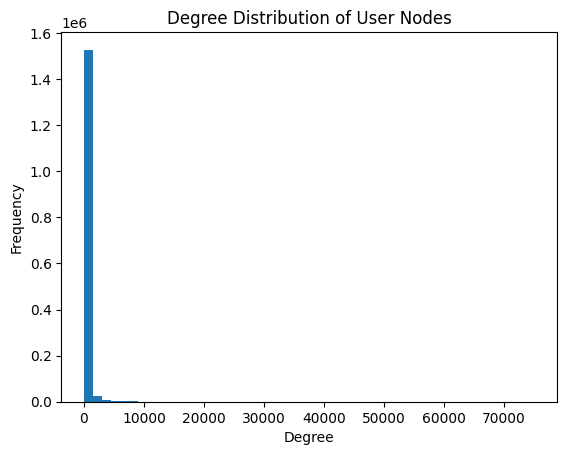

In [ ]:
import matplotlib.pyplot as plt
import torch

# Calculate node degrees
degrees = torch.bincount(data.edge_index[0])  # Degree for user nodes

# Plot degree distribution
plt.hist(degrees.numpy(), bins=50)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of User Nodes')
plt.show()


### Edge Attributes

In [ ]:
# Inspect edge attributes
if data.edge_attr is not None:
    print(f"Edge attributes sample:\n{data.edge_attr[:5]}")

    # Example: Histogram of edge attributes (e.g., interaction type or timestamp)
    plt.hist(data.edge_attr.numpy(), bins=50)
    plt.xlabel('Edge Attribute Value')
    plt.ylabel('Frequency')
    plt.title('Edge Attribute Distribution')
    plt.show()


### Node Features

Mean feature value: 2.1698715499951504e-05
Standard deviation: 0.9996364712715149


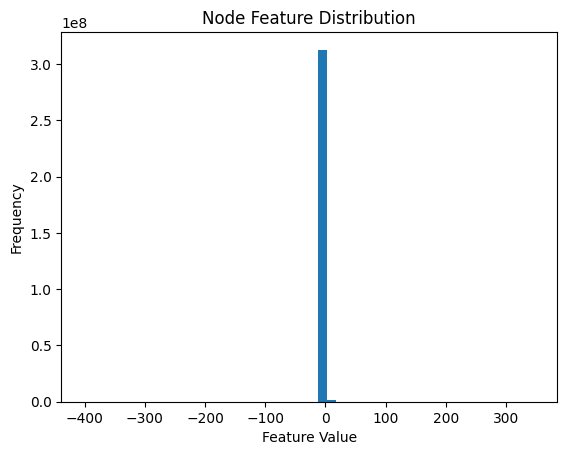

In [ ]:
# Summary statistics for node features
node_features = data.x.numpy()  # Convert to NumPy for easier manipulation
print(f"Mean feature value: {node_features.mean()}")
print(f"Standard deviation: {node_features.std()}")

# Visualize feature distribution
plt.hist(node_features.flatten(), bins=50)
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title('Node Feature Distribution')
plt.show()


### Class Distibution

Label distribution:
tensor([165504406,   2481314])


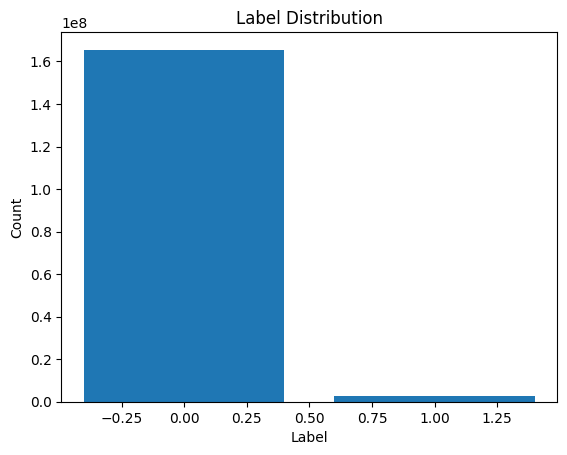

In [ ]:
# Count label occurrences
if data.y is not None:
    # Convert data.y to a 1D tensor with non-negative integer values
    labels = data.y.view(-1).long()  # Flatten and convert to long (int64)

    # Filter out negative values if present
    labels = labels[labels >= 0]

    label_counts = torch.bincount(labels)
    print(f"Label distribution:\n{label_counts}")

    # Plot label distribution
    plt.bar(range(len(label_counts)), label_counts.numpy())
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.show()

## Preprocessing

### Normalize Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data.x = torch.tensor(scaler.fit_transform(data.x.numpy()), dtype=torch.float)


### Split Data into Train/Validate/Test Masks

In [ ]:
# Extract train/val/test indices
train_idx = data.train_mask.nonzero(as_tuple=True)[0]
val_idx = data.val_mask.nonzero(as_tuple=True)[0]
test_idx = data.test_mask.nonzero(as_tuple=True)[0]

print(f"Train set size: {train_idx.size(0)}")
print(f"Validation set size: {val_idx.size(0)}")
print(f"Test set size: {test_idx.size(0)}")


Train set size: 1255968
Validation set size: 78498
Test set size: 235494


## Visualization

### Node Degree

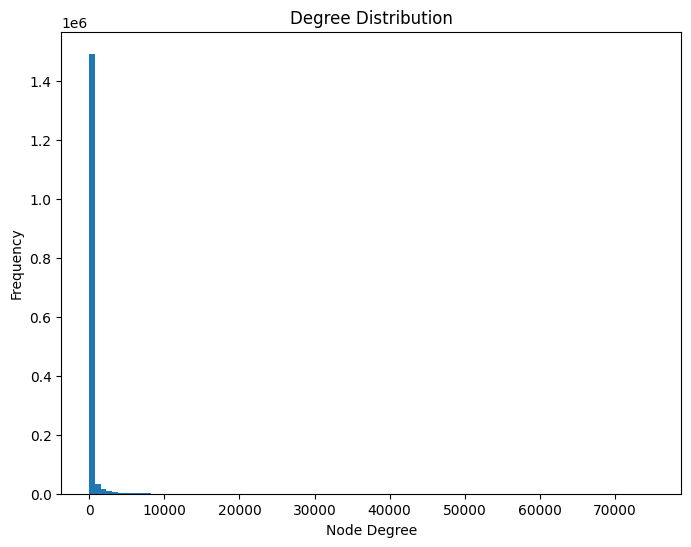

In [ ]:
import matplotlib.pyplot as plt
import torch

# Calculate degrees of nodes
degrees = torch.bincount(data.edge_index[0])  # Degree of user nodes

# Plot the degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degrees.numpy(), bins=100)
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()


### Subgraph

#### Identify High Degree Node

In [ ]:
# Calculate node degrees
degrees = torch.bincount(data.edge_index[0])  # Degrees of all nodes

# Find a node with a high degree
high_degree_node = degrees.argmax().item()  # Node with the highest degree
print(f"High-degree node: {high_degree_node}, Degree: {degrees[high_degree_node]}")


High-degree node: 252569, Degree: 75134


#### Identify Moderately Connected Node


In [ ]:
# Sort nodes by degree
degrees = torch.bincount(data.edge_index[0])
sorted_degrees, sorted_nodes = torch.sort(degrees)

# Select a node with a moderate degree
moderate_node_idx = sorted_nodes[len(sorted_nodes) // 2].item()  # Median degree node
print(f"Moderate-degree node: {moderate_node_idx}, Degree: {degrees[moderate_node_idx]}")


Moderate-degree node: 48123, Degree: 4


#### Extract and Visualize Subgraph

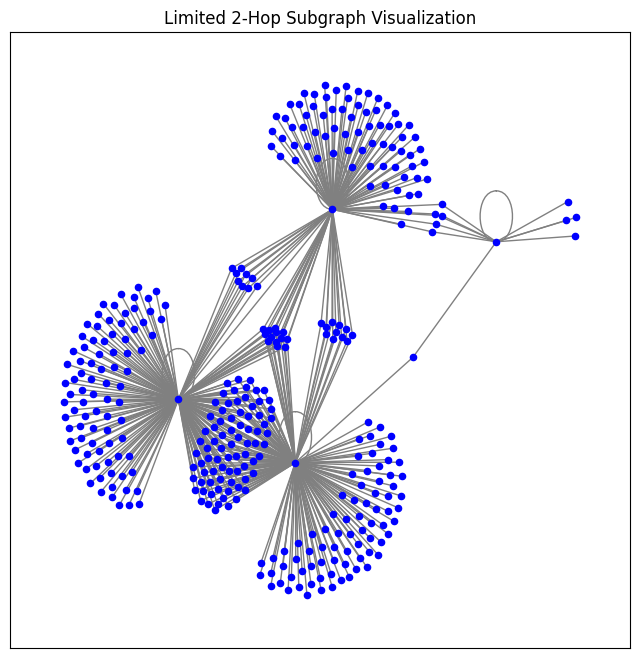

In [ ]:
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
import matplotlib.pyplot as plt

# Extract a 2-hop subgraph around the moderate-degree node
subset, edge_index, _, _ = k_hop_subgraph(moderate_node_idx, num_hops=2, edge_index=data.edge_index)

# Limit the number of edges to visualize
max_edges = 500  # Maximum edges for visualization
edge_index = edge_index[:, :max_edges] if edge_index.size(1) > max_edges else edge_index

# Convert to a NetworkX graph
G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())

# Visualize the subgraph
plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,
    with_labels=False,
    node_size=20,
    node_color='blue',
    edge_color='gray'
)
plt.title('Limited 2-Hop Subgraph Visualization')
plt.show()



#### Subgraph of Randomly Sampled Neighbors

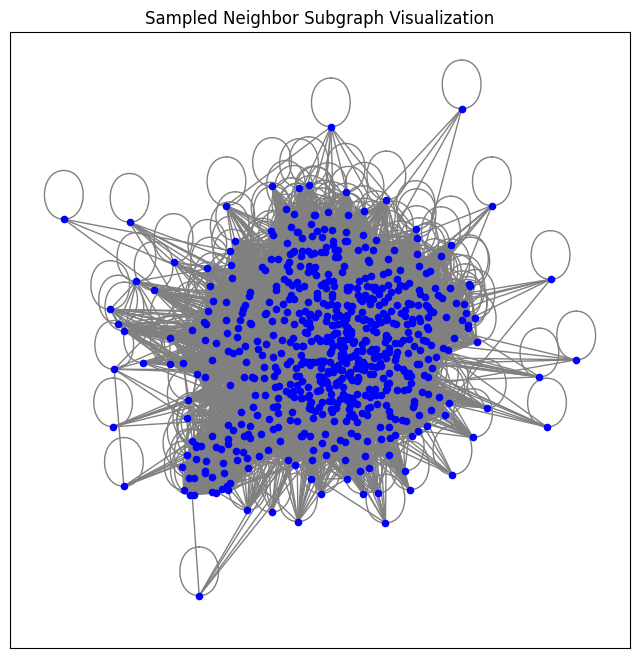

In [ ]:
import random

# Function to sample neighbors for a node
def sample_neighbors(edge_index, node_idx, max_neighbors):
    neighbors = edge_index[1][edge_index[0] == node_idx]  # Find neighbors
    if len(neighbors) > max_neighbors:
        neighbors = random.sample(neighbors.tolist(), max_neighbors)
    return neighbors

# Sample neighbors for a more manageable subgraph
node_idx = moderate_node_idx
max_neighbors = 50

sampled_neighbors = sample_neighbors(data.edge_index, node_idx, max_neighbors)

# Create subgraph with sampled neighbors
subset, edge_index, _, _ = k_hop_subgraph(sampled_neighbors, num_hops=1, edge_index=data.edge_index)

# Visualize the smaller subgraph
G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())

plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,
    with_labels=False,
    node_size=20,
    node_color='blue',
    edge_color='gray'
)
plt.title('Sampled Neighbor Subgraph Visualization')
plt.show()


### Feature Exploration

#### Node Feature Dimensions

In [ ]:
# Dimensions of node features
print(f"Node features shape: {data.x.size()}")


Node features shape: torch.Size([1569960, 200])


#### Inspect Node Features

In [ ]:
# Inspect the first 5 nodes' features
print("First 5 nodes' features:")
print(data.x[:5])


First 5 nodes' features:
tensor([[-1.4745e-01,  2.1791e-01, -3.5770e-01,  1.4947e-01, -7.0304e-02,
         -2.3406e-01, -4.0374e-01,  2.4565e-01, -3.0384e-01,  6.4290e-01,
         -1.3059e-01, -1.2904e-02,  3.5530e-01,  1.4663e-02, -1.0180e-01,
          1.4978e-02,  6.3788e-01,  5.9803e-04,  9.6686e-02,  1.0743e-02,
         -3.0763e-01, -4.9717e-01, -1.1485e-01, -9.5753e-02,  1.5560e-02,
          2.9995e-01,  1.5790e-02,  3.3029e-01,  2.4060e-01,  4.3792e-01,
         -2.4012e-01,  2.1412e-01,  6.8750e-02,  7.3781e-02, -5.1533e-02,
         -4.2834e-01,  4.1978e-02, -1.8573e-01,  5.1977e-03, -1.6126e-02,
          2.8551e-01, -8.7932e-02,  2.5111e-01, -1.7856e-01,  1.0213e-01,
         -3.8754e-01,  2.4183e-01, -1.3415e-01,  9.4095e-02,  2.8125e-01,
          1.8541e-01,  4.8064e-03,  8.6504e-02, -9.7177e-02,  3.3033e-01,
          1.6116e-01,  5.5821e-02, -1.2520e-01, -2.6151e-01,  2.3926e-01,
         -3.9627e-01,  1.7515e-01,  8.7947e-02,  2.1636e-01, -1.8648e-01,
         -2.2

#### Feature Distribution

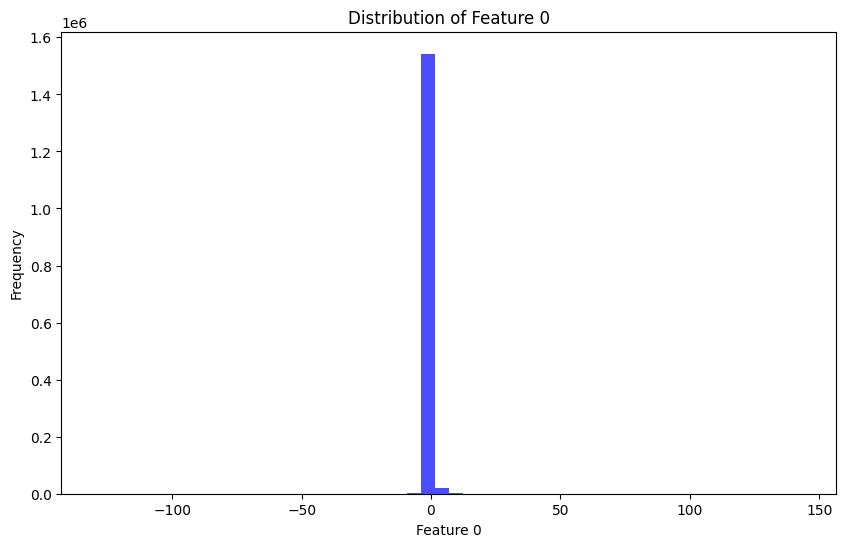

In [ ]:
import matplotlib.pyplot as plt

# Visualize the distribution of the first feature
feature_idx = 0  # Feature to inspect
feature_values = data.x[:, feature_idx].numpy()

plt.figure(figsize=(10, 6))
plt.hist(feature_values, bins=50, alpha=0.7, color='blue')
plt.xlabel(f'Feature {feature_idx}')
plt.ylabel('Frequency')
plt.title(f'Distribution of Feature {feature_idx}')
plt.show()


#### Mapping Features to Node Types

In [ ]:
# Assuming users are the first N nodes and products are the remaining
num_users = torch.sum(data.train_mask)  # Or any other way to identify user nodes
user_features = data.x[:num_users]
product_features = data.x[num_users:]

print("User features shape:", user_features.size())
print("Product features shape:", product_features.size())


User features shape: torch.Size([1255968, 200])
Product features shape: torch.Size([313992, 200])


#### Checking Edge Attributes

In [ ]:
if data.edge_attr is not None:
    print("Edge attributes shape:", data.edge_attr.size())
    print("Sample edge attributes:")
    print(data.edge_attr[:5])  # First 5 edge attributes


# GNN Model

We'll define a Graph Neural Network model and train it using mini-batches to handle the large dataset efficiently.

## Define Model



We'll use the **GraphSAGE** model, suitable for inductive learning and large-scale graphs.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


### Lazy Module

In [ ]:
from torch_geometric.nn import SAGEConv
import torch.nn as nn

class LazyGraphSAGE(torch.nn.Module):
    def __init__(self):
        super(LazyGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(-1, 64)  # Lazy input inference
        self.conv2 = SAGEConv(64, -1)  # Lazy output inference
        self.fc = LazyLinear(out_features=-1)  # Lazy dense layer

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


## Prepare Data for Training



Use `NeighborLoader` to sample mini-batches for training.

In [ ]:
from torch_geometric.loader import NeighborLoader

# Assuming data.y contains node labels
train_idx = data.train_mask.nonzero(as_tuple=True)[0]

# Create a NeighborLoader for training
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  # Sample 15 neighbors in the first layer and 10 in the second
    input_nodes=train_idx,
    batch_size=1024,
    shuffle=True
)

# Similarly, create loaders for validation and test sets
val_idx = data.val_mask.nonzero(as_tuple=True)[0]
test_idx = data.test_mask.nonzero(as_tuple=True)[0]

val_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],
    input_nodes=val_idx,
    batch_size=1024,
    shuffle=False
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],
    input_nodes=test_idx,
    batch_size=1024,
    shuffle=False
)


## Train Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphSAGE(
    in_channels=data.num_features,
    hidden_channels=64,
    num_classes=dataset.num_classes  # Replace with the number of classes in your dataset
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Move node features to device
data.x = data.x.to(device)
data.y = data.y.to(device)

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        # Forward pass
        out = model(batch.x, batch.edge_index)

        # Debugging: Print shapes
        print(f"Output shape: {out.shape}, Target shape: {batch.y.shape}")
        print(f"Sample targets: {batch.y[:5]}")

        # Ensure targets are in the correct format
        if batch.y.dtype != torch.long:
            batch.y = batch.y.to(torch.long)
        if batch.y.dim() > 1:
            batch.y = batch.y.view(-1)

        # Compute the loss
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
    return total_loss / len(train_loader.dataset)




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphSAGE(
    in_channels=data.num_features,
    hidden_channels=64,
    num_classes=dataset.num_classes  # Replace with the number of classes in your dataset
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Move node features to device
data.x = data.x.to(device)
data.y = data.y.to(device)

In [ ]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        # Forward pass
        out = model(batch.x, batch.edge_index)

        # Debugging: Check shapes
        print(f"Model output shape: {out.shape}")
        print(f"Target nodes (global indices): {batch.input_id.shape}")
        print(f"Target shape before slicing: {batch.y.shape}")

        # Create a mapping from global to local indices using n_id
        global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch.n_id)}

        # Map input_id (global indices) to local indices
        target_nodes_local = torch.tensor(
            [global_to_local.get(idx.item(), -1) for idx in batch.input_id], device=device
        )

        # Filter out invalid indices
        target_nodes_local = target_nodes_local[target_nodes_local != -1]

        # Mask outputs and targets for target nodes
        out = out[target_nodes_local]
        batch.y = batch.y[batch.input_id]

        # Debugging: Check shapes after masking
        print(f"Model output shape (after masking): {out.shape}")
        print(f"Target shape (after masking): {batch.y.shape}")

        # Ensure targets are in the correct format
        if batch.y.dtype != torch.long:
            batch.y = batch.y.to(torch.long)

        # Compute the loss
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
    return total_loss / len(train_loader.dataset)



In [ ]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        # Forward pass
        out = model(batch.x, batch.edge_index)

        # Debugging: Check shapes
        print(f"Model output shape: {out.shape}")
        print(f"Target nodes (global indices): {batch.input_id.shape}")
        print(f"Target shape before slicing: {batch.y.shape}")

        # Create a mapping from global to local indices using n_id
        global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch.n_id)}

        # Map input_id (global indices) to local indices
        target_nodes_local = torch.tensor(
            [global_to_local.get(idx.item(), -1) for idx in batch.input_id], device=device
        )

        # Filter out invalid indices
        target_nodes_local = target_nodes_local[target_nodes_local != -1]

        # Mask outputs and targets for target nodes
        out = out[target_nodes_local]
        batch.y = batch.y[target_nodes_local]

        # Debugging: Check shapes after masking
        print(f"Model output shape (after masking): {out.shape}")
        print(f"Target shape (after masking): {batch.y.shape}")

        # Ensure targets are in the correct format
        if batch.y.dtype != torch.long:
            batch.y = batch.y.to(torch.long)

        # Compute the loss
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
    return total_loss / len(train_loader.dataset)


In [ ]:
# Test NeighborLoader output
for batch in train_loader:
    print(f"Batch global node indices (n_id): {batch.n_id.shape}")
    break
print(batch.keys)

Batch global node indices (n_id): torch.Size([46941])
<bound method BaseData.keys of Data(x=[46941, 200], edge_index=[2, 65029], y=[46941, 107], train_mask=[46941], val_mask=[46941], test_mask=[46941], n_id=[46941], e_id=[65029], input_id=[1024], batch_size=1024)>


In [ ]:
def train():
    model.train()
    total_loss = 0
    batch_index=0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        # Forward pass
        out = model(batch.x, batch.edge_index)

        # Create a mapping from global to local indices using n_id
        global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch.n_id)}

        # Map input_id (global indices) to local indices
        target_nodes_local = torch.tensor(
            [global_to_local.get(idx.item(), -1) for idx in batch.input_id], device=device
        )
        target_nodes_local = target_nodes_local[target_nodes_local != -1]

        # Mask outputs and targets for target nodes
        out = out[target_nodes_local]
        batch.y = batch.y[target_nodes_local]

        # Debugging: Check shapes after masking
        if batch_index % 10 == 0:  # Every 10 batches
          print(f"Batch {batch_index}, Output shape: {out.shape}")
        #print(f"Model output shape (after masking): {out.shape}")
        #print(f"Target shape (after masking): {batch.y.shape}")

        # Ensure targets are in the correct format
        if batch.y.dim() > 1:  # Convert one-hot or probabilities to class indices
            batch.y = batch.y.argmax(dim=1)
        if batch.y.dtype != torch.long:
            batch.y = batch.y.to(torch.long)

        # Compute the loss
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes

        batch_index+=1
    return total_loss / len(train_loader.dataset)


#### Updated Training Loop

### Run Training Loop

In [ ]:
for epoch in range(1, 3):  # Train for 10 epochs
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss:.4f}')


Batch 0, Output shape: torch.Size([13, 107])
Batch 10, Output shape: torch.Size([13, 107])
Batch 20, Output shape: torch.Size([9, 107])
Batch 30, Output shape: torch.Size([14, 107])
Batch 40, Output shape: torch.Size([17, 107])
Batch 50, Output shape: torch.Size([13, 107])
Batch 60, Output shape: torch.Size([16, 107])
Batch 70, Output shape: torch.Size([16, 107])
Batch 80, Output shape: torch.Size([12, 107])
Batch 90, Output shape: torch.Size([12, 107])
Batch 100, Output shape: torch.Size([8, 107])
Batch 110, Output shape: torch.Size([15, 107])
Batch 120, Output shape: torch.Size([20, 107])
Batch 130, Output shape: torch.Size([15, 107])
Batch 140, Output shape: torch.Size([14, 107])
Batch 150, Output shape: torch.Size([16, 107])
Batch 160, Output shape: torch.Size([14, 107])
Batch 170, Output shape: torch.Size([7, 107])
Batch 180, Output shape: torch.Size([14, 107])
Batch 190, Output shape: torch.Size([14, 107])
Batch 200, Output shape: torch.Size([9, 107])
Batch 210, Output shape: tor

## Evaluate Model

In [ ]:
def test(loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)

            # Map input_id (global indices) to local indices
            global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch.n_id)}
            target_nodes_local = torch.tensor(
                [global_to_local.get(idx.item(), -1) for idx in batch.input_id], device=device
            )
            target_nodes_local = target_nodes_local[target_nodes_local != -1]

            # Mask outputs and targets for target nodes
            out = out[target_nodes_local]
            batch.y = batch.y[target_nodes_local]

            # Ensure targets are class indices
            if batch.y.dim() > 1:  # If one-hot encoded
                batch.y = batch.y.argmax(dim=1)

            # Predict and calculate accuracy
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)  # Use the correct target size
            print(f"Pred shape: {pred.shape}, Target shape: {batch.y.shape}")


    return correct / total if total > 0 else 0.0


In [ ]:
# Evaluate on validation set
val_accuracy = test(val_loader)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate on test set
test_accuracy = test(test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

## RecSys Metric Evaluation

In [ ]:
import numpy as np

def test_recsys(loader, k=10):
    model.eval()
    hits = []
    ndcgs = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)  # Model output (logits)

            # Map input_id (global indices) to local indices
            global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch.n_id)}
            target_nodes_local = torch.tensor(
                [global_to_local.get(idx.item(), -1) for idx in batch.input_id], device=device
            )
            target_nodes_local = target_nodes_local[target_nodes_local != -1]

            # Mask outputs and targets for target nodes
            out = out[target_nodes_local]
            batch.y = batch.y[target_nodes_local]

            # Ensure targets are class indices
            if batch.y.dim() > 1:  # If one-hot encoded
                batch.y = batch.y.argmax(dim=1)

            # Calculate Hits@K and NDCG@K
            for i in range(out.size(0)):  # Iterate over users/nodes
                true_label = batch.y[i].item()  # True class index
                scores = out[i].cpu().numpy()  # Predicted scores for all classes
                top_k = np.argsort(scores)[-k:][::-1]  # Top K class indices

                # Hits@K
                if true_label in top_k:
                    hits.append(1)
                else:
                    hits.append(0)

                # NDCG@K
                if true_label in top_k:
                    rank = np.where(top_k == true_label)[0][0] + 1  # Rank is 1-based
                    ndcg = 1 / np.log2(rank + 1)
                    ndcgs.append(ndcg)
                else:
                    ndcgs.append(0)

    # Compute averages
    hits_k = np.mean(hits)
    ndcg_k = np.mean(ndcgs)
    return hits_k, ndcg_k


In [ ]:
# Evaluate on validation set
hits_k_val, ndcg_k_val = test_recsys(val_loader, k=10)
print(f'Validation Hits@10: {hits_k_val:.4f}, NDCG@10: {ndcg_k_val:.4f}')

# Evaluate on test set
hits_k_test, ndcg_k_test = test_recsys(test_loader, k=10)
print(f'Test Hits@10: {hits_k_test:.4f}, NDCG@10: {ndcg_k_test:.4f}')


# Advanced Visualization

## t-SNE Node Embeddings

Visualize the learned node embeddings to understand how the model clusters the nodes.

In [ ]:
from sklearn.manifold import TSNE

# Collect embeddings from the entire dataset
embeddings = []
model.eval()
with torch.no_grad():
    for batch in NeighborLoader(data, num_neighbors=[-1], batch_size=1024, input_nodes=None):
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        embeddings.append(out.cpu())

embeddings = torch.cat(embeddings, dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=2, c=data.y.cpu().numpy(), cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()


/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


## Visualize Training Loss

Batch 0, Output shape: torch.Size([15, 107])
Batch 10, Output shape: torch.Size([14, 107])
Batch 20, Output shape: torch.Size([10, 107])
Batch 30, Output shape: torch.Size([11, 107])
Batch 40, Output shape: torch.Size([25, 107])
Batch 50, Output shape: torch.Size([13, 107])
Batch 60, Output shape: torch.Size([13, 107])
Batch 70, Output shape: torch.Size([13, 107])
Batch 80, Output shape: torch.Size([14, 107])
Batch 90, Output shape: torch.Size([17, 107])
Batch 100, Output shape: torch.Size([10, 107])
Batch 110, Output shape: torch.Size([12, 107])
Batch 120, Output shape: torch.Size([13, 107])
Batch 130, Output shape: torch.Size([14, 107])
Batch 140, Output shape: torch.Size([16, 107])
Batch 150, Output shape: torch.Size([11, 107])
Batch 160, Output shape: torch.Size([12, 107])
Batch 170, Output shape: torch.Size([14, 107])
Batch 180, Output shape: torch.Size([19, 107])
Batch 190, Output shape: torch.Size([15, 107])
Batch 200, Output shape: torch.Size([15, 107])
Batch 210, Output shape:

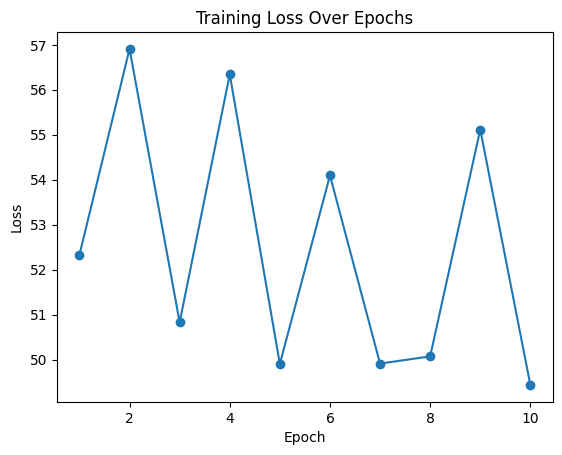

In [ ]:
import matplotlib.pyplot as plt
loss_values = []

for epoch in range(1, 11):
    loss = train()
    loss_values.append(loss)
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Plot the training loss
plt.figure()
plt.plot(range(1, 11), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


In [ ]:
# Evaluate on validation set
val_accuracy = test(val_loader)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate on test set
test_accuracy = test(test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Pred shape: torch.Size([57]), Target shape: torch.Size([57])
Pred shape: torch.Size([19]), Target shape: torch.Size([19])
Pred shape: torch.Size([16]), Target shape: torch.Size([16])
Pred shape: torch.Size([11]), Target shape: torch.Size([11])
Pred shape: torch.Size([18]), Target shape: torch.Size([18])
Pred shape: torch.Size([15]), Target shape: torch.Size([15])
Pred shape: torch.Size([11]), Target shape: torch.Size([11])
Pred shape: torch.Size([13]), Target shape: torch.Size([13])
Pred shape: torch.Size([14]), Target shape: torch.Size([14])
Pred shape: torch.Size([9]), Target shape: torch.Size([9])
Pred shape: torch.Size([16]), Target shape: torch.Size([16])
Pred shape: torch.Size([16]), Target shape: torch.Size([16])
Pred shape: torch.Size([10]), Target shape: torch.Size([10])
Pred shape: torch.Size([7]), Target shape: torch.Size([7])
Pred shape: torch.Size([17]), Target shape: torch.Size([17])
Pred shape: torch.Size([13]), Target shape: torch.Size([13])
Pred shape: torch.Size([20])

## Product Specific Metrics

In [ ]:
import numpy as np

def test_recsys(loader, k=10):
    model.eval()
    hits = []
    ndcgs = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)  # Model output (logits)

            # Map input_id (global indices) to local indices
            global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch.n_id)}
            target_nodes_local = torch.tensor(
                [global_to_local.get(idx.item(), -1) for idx in batch.input_id], device=device
            )
            target_nodes_local = target_nodes_local[target_nodes_local != -1]

            # Mask outputs and targets for target nodes
            out = out[target_nodes_local]
            batch.y = batch.y[target_nodes_local]

            # Ensure targets are class indices
            if batch.y.dim() > 1:  # If one-hot encoded
                batch.y = batch.y.argmax(dim=1)

            # Calculate Hits@K and NDCG@K
            for i in range(out.size(0)):  # Iterate over users/nodes
                true_label = batch.y[i].item()  # True class index
                scores = out[i].cpu().numpy()  # Predicted scores for all classes
                top_k = np.argsort(scores)[-k:][::-1]  # Top K class indices

                # Hits@K
                if true_label in top_k:
                    hits.append(1)
                else:
                    hits.append(0)

                # NDCG@K
                if true_label in top_k:
                    rank = np.where(top_k == true_label)[0][0] + 1  # Rank is 1-based
                    ndcg = 1 / np.log2(rank + 1)
                    ndcgs.append(ndcg)
                else:
                    ndcgs.append(0)

    # Compute averages
    hits_k = np.mean(hits)
    ndcg_k = np.mean(ndcgs)
    return hits_k, ndcg_k


In [ ]:
# Evaluate on validation set
hits_k_val, ndcg_k_val = test_recsys(val_loader, k=10)
print(f'Validation Hits@10: {hits_k_val:.4f}, NDCG@10: {ndcg_k_val:.4f}')

# Evaluate on test set
hits_k_test, ndcg_k_test = test_recsys(test_loader, k=10)
print(f'Test Hits@10: {hits_k_test:.4f}, NDCG@10: {ndcg_k_test:.4f}')


Validation Hits@10: 0.8768, NDCG@10: 0.6970
Test Hits@10: 0.8832, NDCG@10: 0.7138
